# パフォーマンスを集約

In [32]:
import pandas as pd
import glob
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score
import numpy as np

In [5]:
fn_l = glob.glob("../data/result/*.csv")
fn_l.sort()
fn_l

['../data/result/m10_w13_b128.csv',
 '../data/result/m10_w13_b256.csv',
 '../data/result/m10_w4_b128.csv',
 '../data/result/m10_w4_b256.csv',
 '../data/result/m9_w13_b128.csv',
 '../data/result/m9_w13_b256.csv',
 '../data/result/m9_w4_b128.csv',
 '../data/result/m9_w4_b256.csv']

In [6]:
data_d = dict()
for fn_i in fn_l:
    df = pd.read_csv(fn_i, parse_dates=["date"])
    data_d.update({fn_i: df.copy()})

In [7]:
for k, v in data_d.items():
    print(k)

../data/result/m10_w13_b128.csv
../data/result/m10_w13_b256.csv
../data/result/m10_w4_b128.csv
../data/result/m10_w4_b256.csv
../data/result/m9_w13_b128.csv
../data/result/m9_w13_b256.csv
../data/result/m9_w4_b128.csv
../data/result/m9_w4_b256.csv


## training data

In [8]:
def calculate_average(data_d: dict, coln: str) -> pd.DataFrame:
    result_l = list()
    for k, v in data_d.items():
        # 全期間
        all_ = v[coln].mean()
        # last 5yr
        last5yr = v[coln].iloc[-52*5:].mean()
        # last 3yr
        last3yr = v[coln].iloc[-52*3:].mean()
        # last 1yr
        last1yr = v[coln].iloc[-52*1:].mean()
        result_l.append([k, all_, last5yr, last3yr, last1yr])

    result_df = pd.DataFrame(result_l, columns=["key", "all", "last5yr", "last3yr", "last1yr"])
    return result_df

In [9]:
calculate_average(data_d, "training_loss")

,key,all,last5yr,last3yr,last1yr
0,../data/result/m10_w13_b128.csv,0.499901,0.511822,0.498888,0.330645
1,../data/result/m10_w13_b256.csv,0.506000,0.544579,0.521200,0.471452
2,../data/result/m10_w4_b128.csv,0.488623,0.473093,0.489467,0.517488
3,../data/result/m10_w4_b256.csv,0.500465,0.480866,0.458517,0.458958
4,../data/result/m9_w13_b128.csv,0.517674,0.543444,0.569586,0.699743
5,../data/result/m9_w13_b256.csv,0.526082,0.528321,0.547368,0.467735
6,../data/result/m9_w4_b128.csv,0.510577,0.506648,0.536275,0.602878
7,../data/result/m9_w4_b256.csv,0.497743,0.490469,0.476350,0.499778


## correlation

In [10]:
def calculate_correlation(data_d: dict) -> pd.DataFrame:
    """ drtnfとprobの送還を計算 """
    result_l = list()
    for k, v in data_d.items():
        # 全期間
        all_ = v[["prob", "drtnf"]].corr().iloc[0, 1]
        # last 5yr
        last5yr = v[["prob", "drtnf"]].iloc[-52*5:].corr().iloc[0, 1]
        # last 3yr
        last3yr = v[["prob", "drtnf"]].iloc[-52*3:].corr().iloc[0, 1]
        # last 1yr
        last1yr = v[["prob", "drtnf"]].iloc[-52*1:].corr().iloc[0, 1]
        result_l.append([k, all_, last5yr, last3yr, last1yr])

    result_df = pd.DataFrame(result_l, columns=["key", "all", "last5yr", "last3yr", "last1yr"])
    return result_df

In [11]:
calculate_correlation(data_d)

,key,all,last5yr,last3yr,last1yr
0,../data/result/m10_w13_b128.csv,0.019976,-0.019266,0.029983,0.379816
1,../data/result/m10_w13_b256.csv,-0.007455,-0.087399,-0.124952,-0.615496
2,../data/result/m10_w4_b128.csv,0.049075,0.032452,0.080538,0.268310
3,../data/result/m10_w4_b256.csv,-0.021121,0.003217,0.048322,0.170021
4,../data/result/m9_w13_b128.csv,0.009652,-0.017965,-0.131644,0.113642
5,../data/result/m9_w13_b256.csv,-0.008869,0.057791,-0.098971,-0.067554
6,../data/result/m9_w4_b128.csv,0.006966,-0.075329,-0.017193,0.180243
7,../data/result/m9_w4_b256.csv,0.017212,-0.006380,-0.071463,-0.050463


## accuracy f1

In [24]:
def calculate_score(data_d: dict) -> dict:
    result_l = list()
    for k, v in data_d.items():
        true_l = [1 if x >= 0 else 0 for x in v["drtnf"]]
        pred_l = [1 if x >= 0.5 else 0 for x in v["prob"]]

        accuracy_score_ = accuracy_score(true_l, pred_l)
        precision_score_ = precision_score(true_l, pred_l)
        recall_score_ = recall_score(true_l, pred_l)
        f1_score_ = f1_score(true_l, pred_l)
        #fbeta_score_ = fbeta_score(true_l, pred_l)

        #result_l.append([k, accuracy_score_, precision_score_, recall_score_, f1_score_, fbeta_score_])
        result_l.append([k, accuracy_score_, precision_score_, recall_score_, f1_score_])

    #df = pd.DataFrame(result_l, columns=["key", "accuracy", "precision", "recall", "f1", "fbeta"])
    df = pd.DataFrame(result_l, columns=["key", "accuracy", "precision", "recall", "f1"])
    return df

In [25]:
calculate_score(data_d)

,key,accuracy,precision,recall,f1
0,../data/result/m10_w13_b128.csv,0.489547,0.555184,0.182018,0.274154
1,../data/result/m10_w13_b256.csv,0.487224,0.551237,0.171053,0.261088
2,../data/result/m10_w4_b128.csv,0.487805,0.552083,0.174342,0.265000
3,../data/result/m10_w4_b256.csv,0.479094,0.527881,0.155702,0.240474
4,../data/result/m9_w13_b128.csv,0.481417,0.533569,0.165570,0.252720
5,../data/result/m9_w13_b256.csv,0.477352,0.522059,0.155702,0.239865
6,../data/result/m9_w4_b128.csv,0.488386,0.549521,0.188596,0.280816
7,../data/result/m9_w4_b256.csv,0.478513,0.523649,0.169956,0.256623


## 戦略

In [30]:
def calculate_strategy_performance(data_d: dict, beta: float = 0.1) -> pd.DataFrame:
    """戦略のパフォーマンス計算"""
    result_l = list()
    for k, v in data_d.items():
        rtn_s = v["drtnf"].copy()
        mask = v["prob"] >= 0.5
        rtn_s[~mask] = 0
        rtn_s[mask] = rtn_s[mask] * beta

        alpha_ = rtn_s.mean() * 52
        te_ = rtn_s.std() * np.sqrt(52)
        ir_ = alpha_ / te_

        result_l.append([k, alpha_, te_, ir_])

    df = pd.DataFrame(result_l, columns=["key", "alpha", "te_", "ir_"])
    return df

In [33]:
calculate_strategy_performance(data_d)

,key,alpha,te_,ir_
0,../data/result/m10_w13_b128.csv,0.002870,0.008812,0.325699
1,../data/result/m10_w13_b256.csv,0.001882,0.008229,0.228693
2,../data/result/m10_w4_b128.csv,0.002792,0.008650,0.322712
3,../data/result/m10_w4_b256.csv,0.001147,0.008308,0.138087
4,../data/result/m9_w13_b128.csv,0.001566,0.008411,0.186222
5,../data/result/m9_w13_b256.csv,0.000551,0.008138,0.067652
6,../data/result/m9_w4_b128.csv,0.001588,0.008740,0.181746
7,../data/result/m9_w4_b256.csv,0.002738,0.008750,0.312877


In [70]:
def draw_strategy(data_d: dict, beta: float = 0.1) -> pd.DataFrame:
    """戦略のグラフ表示"""
    result_l = list()
    for k, v in data_d.items():
        rtn_df = v.set_index("date")[["drtnf", "prob"]].copy()
        rtn_df.dropna(how="any", axis="index", inplace=True)

        mask = rtn_df["prob"] >= 0.5
        rtn_df.loc[~mask, "drtnf"] = 0
        rtn_df.loc[mask, "drtnf"] = rtn_df[mask]["drtnf"].mul(beta)

        rtn_s = rtn_df["drtnf"]
        rtn_s.name = k

        result_l.append(rtn_s)

    df = pd.concat(result_l, axis="columns")
    return df

In [71]:
df = draw_strategy(data_d)

<AxesSubplot:xlabel='date'>

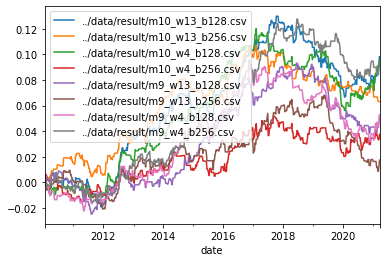

In [72]:
df.add(1).cumprod(axis="index").sub(1).plot()